# СЕМИНАР 6: ПРЕДПОСЫЛКИ ГАУССА-МАРКОВА

Поговорив и подумав об условиях, которые должны выполняться для достижения BLUE оценок, становится понятно, что в реальной жизни предпосылки Г-М едва ли достижимы

Тем не менее, в погоне за интерпретируемостью эконометрика активно разрабатывает тесты на проверку условий Г-М (их правда очень-очень много)

А также способы "обойти" условия Г-М и получить как можно "лучшие" оценки с точки зрения несмещенности, состоятельности, эффективности

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(123)

import scipy as sp
from scipy.stats import t

import statsmodels.stats.diagnostic as smd 
import statsmodels.formula.api as smf 
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as smst

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import unicodedata

## Автокорреляция

Приведем реализацию способов, которыми можно обнаружить автокорреляцию:

In [39]:
np.random.seed(42) 
n = 200 

x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)

# Создаем автокоррелированные ошибки (процесс AR(1))
epsilon = np.zeros(n)
rho = 0.7  
for t in range(1, n):
    epsilon[t] = rho * epsilon[t-1] + np.random.normal(0, 1)

true_beta = [2, 1.5, -0.8]  # истинные коэффициенты
y = true_beta[0] + true_beta[1] * x1 + true_beta[2] * x2 + epsilon

df = pd.DataFrame({
    'y': y,
    'x1': x1,
    'x2': x2
})

df

,y,x1,x2
0,2.458841,0.496714,0.357787
1,-0.250452,-0.138264,0.560785
2,0.389617,0.647689,1.083051
3,2.245915,1.523030,1.053802
4,1.960974,-0.234153,-1.377669
...,...,...,...
195,4.237841,0.385317,-0.469176
196,2.433872,-0.883857,-1.713135
197,1.150020,0.153725,1.353872
198,1.201952,0.058209,-0.114540


In [40]:
X = sm.add_constant(df[['x1', 'x2']])  # добавляем константу
model = sm.OLS(df['y'], X).fit()

print(model.summary())

# Сохраняем остатки
residuals = model.resid
print(f"\nПервые 10 остатков: {residuals[:10]}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     121.1
Date:                 Пт, 24 окт 2025   Prob (F-statistic):           4.99e-35
Time:                        16:05:07   Log-Likelihood:                -351.16
No. Observations:                 200   AIC:                             708.3
Df Residuals:                     197   BIC:                             718.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7275      0.100     17.223      0.0

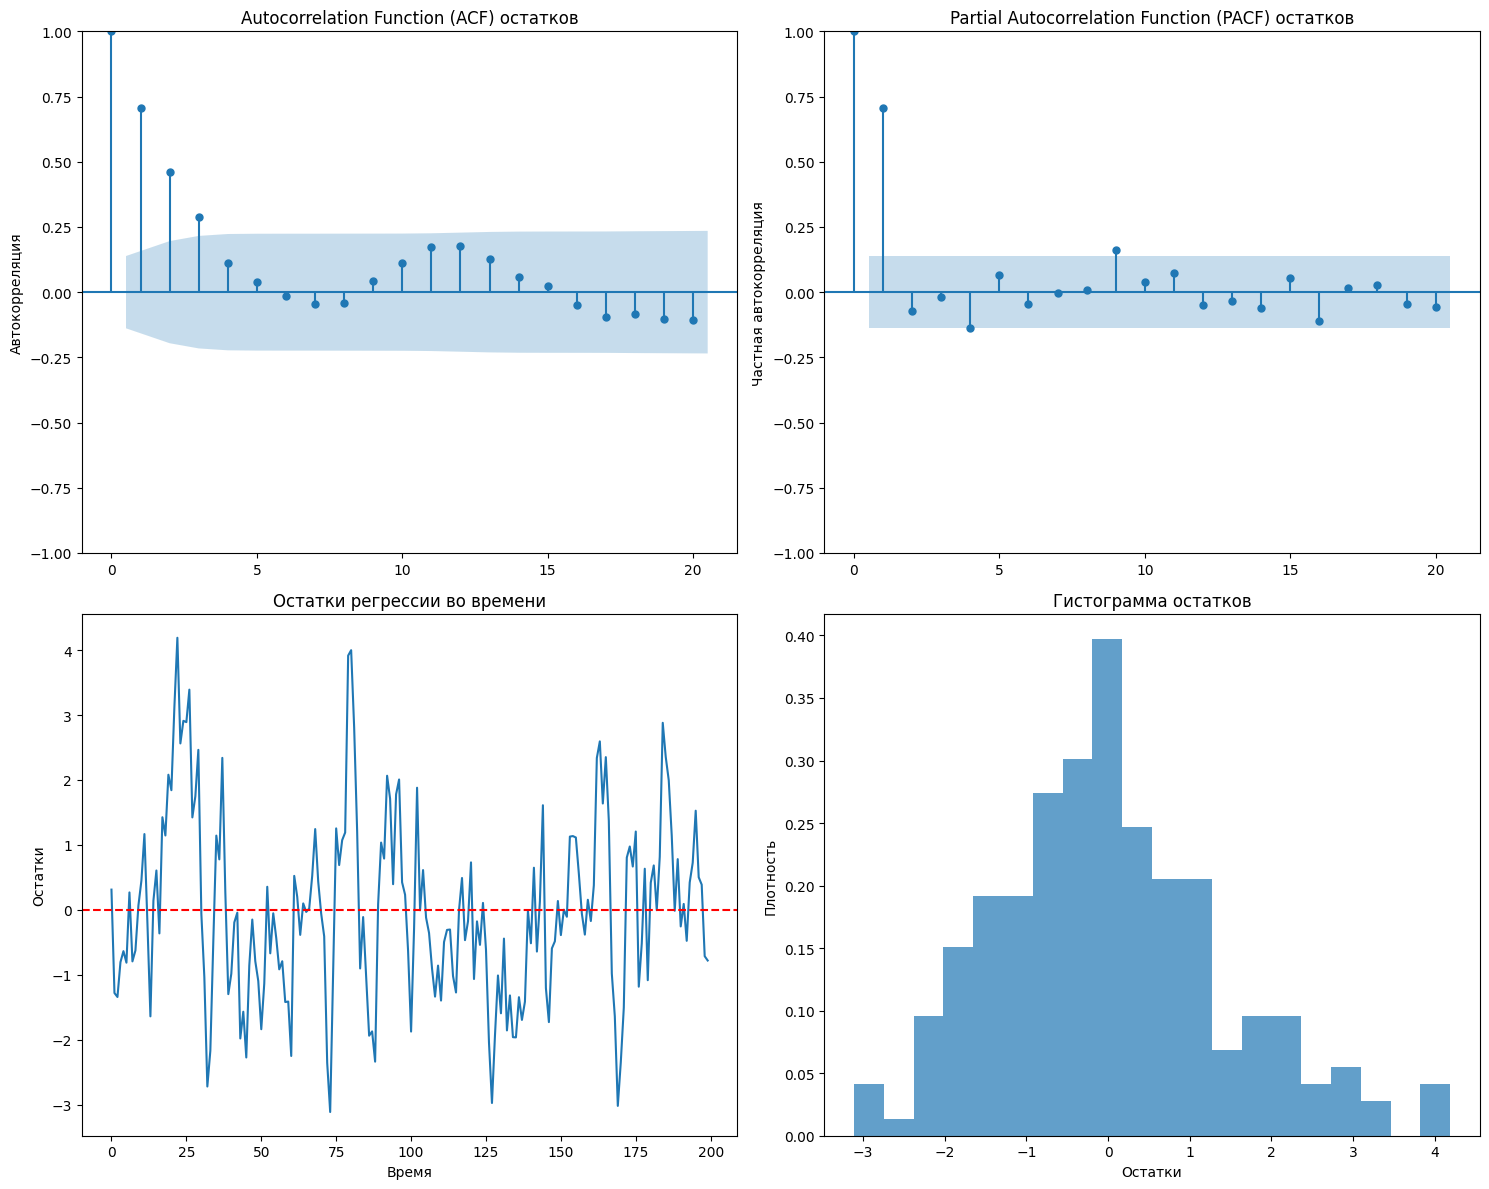

In [44]:
# Графический анализ автокорреляции
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 3.1 ACF остатков
plot_acf(residuals, ax=axes[0, 0], lags=20, alpha=0.05)
axes[0, 0].set_title('Autocorrelation Function (ACF) остатков')
axes[0, 0].set_ylabel('Автокорреляция')

# 3.2 PACF остатков
plot_pacf(residuals, ax=axes[0, 1], lags=20, alpha=0.05, method='ywm')
axes[0, 1].set_title('Partial Autocorrelation Function (PACF) остатков')
axes[0, 1].set_ylabel('Частная автокорреляция')

# 3.3 Остатки во времени
axes[1, 0].plot(residuals)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('Остатки регрессии во времени')
axes[1, 0].set_xlabel('Время')
axes[1, 0].set_ylabel('Остатки')

# 3.4 Распределение остатков
axes[1, 1].hist(residuals, bins=20, density=True, alpha=0.7)
axes[1, 1].set_title('Гистограмма остатков')
axes[1, 1].set_xlabel('Остатки')
axes[1, 1].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

In [46]:
# Тест Дарбина-Ватсона
dw_stat = durbin_watson(residuals)
print(f"Статистика Дарбина-Ватсона: {dw_stat:.4f}")

# Интерпретация
if dw_stat < 1.5:
    print(" Сильная положительная автокорреляция")
elif dw_stat < 2.0:
    print(" Слабая положительная автокорреляция")
elif dw_stat == 2.0:
    print(" Нет автокорреляции")
elif dw_stat < 2.5:
    print("Слабая отрицательная автокорреляция")
else:
    print(" Сильная отрицательная автокорреляция")

Статистика Дарбина-Ватсона: 0.5874
 Сильная положительная автокорреляция


In [48]:
# Тест Льюнга-Бокса
ljung_box_results = acorr_ljungbox(residuals, lags=10, return_df=True)
print("Результаты теста Льюнга-Бокса:")
print(ljung_box_results)

# Проверяем гипотезу для нескольких лагов
print("\nПроверка гипотез:")
for lag in [5, 10]:
    lb_test = acorr_ljungbox(residuals, lags=[lag], return_df=True)
    p_value = lb_test['lb_pvalue'].iloc[0]
    print(f"Лаг {lag}: p-value = {p_value:.4f} - ", 
          "Есть автокорреляция" if p_value < 0.05 else "Нет автокорреляции")

Результаты теста Льюнга-Бокса:
       lb_stat     lb_pvalue
1   101.019143  9.109878e-24
2   144.513932  4.161006e-32
3   161.666888  8.005599e-35
4   164.172569  1.861696e-34
5   164.473055  1.101509e-33
6   164.525058  6.512827e-33
7   164.985454  2.861057e-32
8   165.339771  1.220868e-31
9   165.714937  4.813754e-31
10  168.404484  5.934558e-31

Проверка гипотез:
Лаг 5: p-value = 0.0000 -  Есть автокорреляция
Лаг 10: p-value = 0.0000 -  Есть автокорреляция


## Гетероскедастичность

Text(0.5, 1.0, 'With no scale')

<Figure size 1000x1000 with 0 Axes>

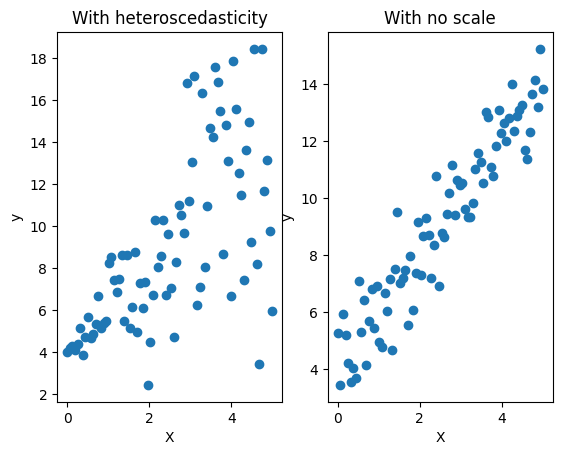

In [3]:
x = np.linspace(0,5,80)

y1 = 4 + 2*x +np.random.normal(scale = x,size=x.shape)
y2 =  4 + 2*x +np.random.normal(size=x.shape)

plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols=  2)
axes[0].scatter(x, y1)
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[0].set_title("With heteroscedasticity")


axes[1].scatter(x, y2)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("With no scale")

**Последствия гетероскедастичности**

Если предположение об одинаковых дисперсиях ошибок не
выполняется, то
* стандартные ошибки коэффициентов регрессии вычисляются
по неверным формулам
* t – тесты для проверки гипотез о конкретных значениях
коэффициентов не дают правильных результатов
* F – тесты для проверки гипотез о линейных ограничениях на
коэффициенты регрессии не дают правильных результатов
* Теряется эффективность оценок МНК.

Сгенерируем выборку в 50 наблюдений и оценим ее с помощью МНК

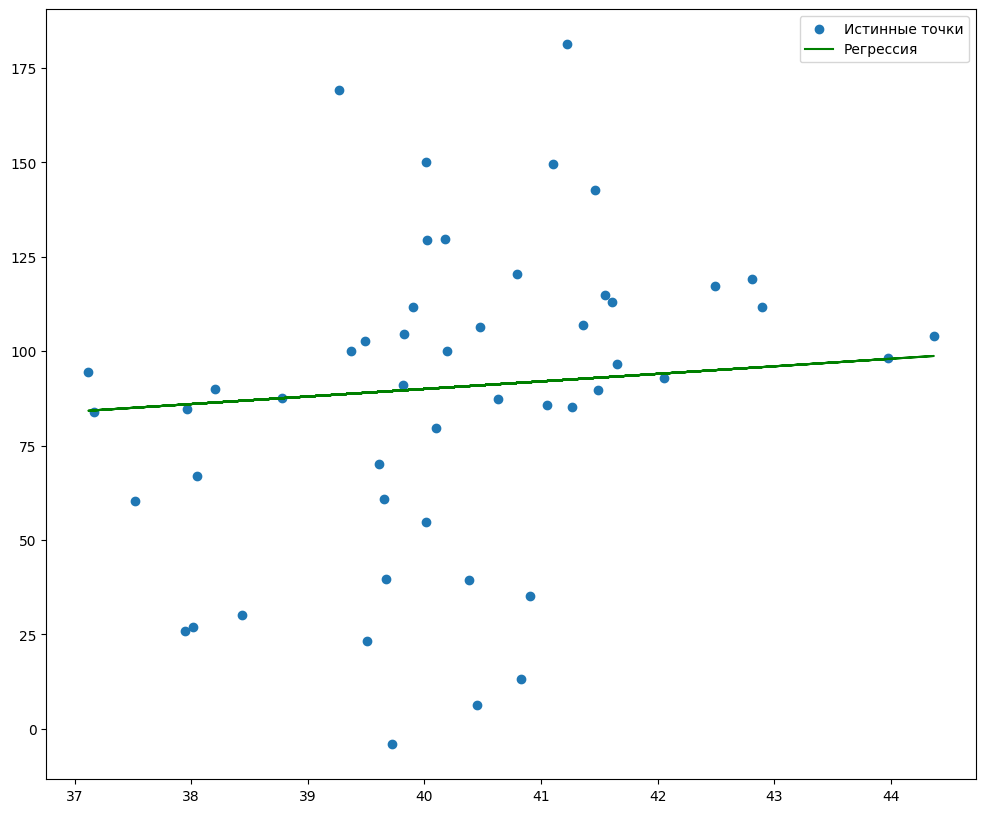

In [12]:
x = np.random.normal(loc=40.0, scale=2.0, size=50)
eps = np.random.normal(loc=0.0, scale=x, size=50)
y = 10+2*x+eps

plt.figure(figsize=(12, 10))
plt.scatter(x, y, label='Истинные точки')
plt.plot(x, y-eps, c='g', label='Регрессия')
plt.legend()
plt.show()

In [13]:
data = pd.DataFrame(np.vstack([x, y]).T, columns=['x', 'y'])
data.head()
model = smf.ols(data=data, formula='y ~ x').fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     5.701
Date:                Fri, 24 Oct 2025   Prob (F-statistic):             0.0209
Time:                        14:11:02   Log-Likelihood:                -253.70
No. Observations:                  50   AIC:                             511.4
Df Residuals:                      48   BIC:                             515.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -246.5473    140.066     -1.760      0.085    -528.170      35.075
x              8.3025      3.477      2.388      0.021       1.311      15.294
==============================================================================
Omnibus:                        0.598   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.218
Skew:                          -0.151   Prob(JB):                        0.897
Kurtosis:                       3.114   Cond. No.                     1.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Тест Голдьфельда-Квандта

Проведём тест **Голдфельда-Квандта** на гетероскедастичность:
$$H_0: ∀ i: \sigma^2_i = \sigma^2$$
$$H_1: ∃ i, j: \sigma_i != \sigma_j$$

Для проведения теста Голдфелда – Квандта все наблюдения
упорядочиваются по Хj и делятся на 3 части. Если выборка
небольшая, то выделяют приблизительно 3/8 части всех
наблюдений для первой и третьей части и приблизительно 1/4
в середине.

Мы будем использовать тест из statmodels:

Напомним описание алгоритма Голдфелда – Квандта:

* Упорядочиваем все наблюдения по модулю подозрительной переменной.

* Делим все наблюдения на три группы (если наблюдений достаточно много, то
приблизительно на трети). Удобно, если в первой и третьей группах количество
наблюдений одинаково.

* Наблюдениями средней группы пренебрегаем, а по первым n1 и последним n2наблюдениям оцениваем отдельные регрессии.

* Используя суммы квадратов остатков (RSS) в оцененных регрессиях,
рассчитываем тестовую статистику по формуле в первой и третий группе

* Сравниваем полученное значение F – статистики с критическим (при выбранном
уровне значимости).

* Если значение F – статистики превышает критическое, нулевая гипотеза о
гомоскедастичности отвергается.

In [14]:
sms.het_goldfeldquandt(y=model.model.endog, x=model.model.exog, alternative='increasing')

(0.9647299091877429, 0.5339366464748196, 'increasing')

In [ ]:
### ПРОИНТЕРПРЕТИРУЙТЕ РЕЗУЛЬТАТЫ ТЕСТА, ЕСТЬ ЛИ ГЕТЕРОСКЕДАСТИЧНОСТЬ?

### Тест Бреуша-Пагана

1. МНК-оценка коэффициентов и остатков модели
2. Подсчёт статистики $g_i=\frac{\hat{ɛ}_i^2}{\hat{\sigma}^2}$
3. МНК-оценка регрессии типа $g_i=\gamma Z_{i}+\eta_i$, где $Z$ - признаки, выбранные для оценки гетероскедастичности (обычно $Z=X$, но Z также может быть подмножеством Х или ещё как-либо модифицированным)
4. Посчитать статистику $LM=0.5(ESS_{auxilary})\sim \chi^2(shape(Z))$, где $ESS=\sum (\hat{g_i}-\overline{g})^2$

В statsmodels вывод следующий:
1. Значение LM статистики
2. Значение p-value для LM
3. Значение F статистики (значимость регрессии на остатки, H_0 - модель не значима в целом)
4. Значение p-value для F

In [15]:
sms.het_breuschpagan(model.resid, model.model.exog)

(0.22995367592335558,
 0.631558179219206,
 0.22177549067261898,
 0.6398236351996947)

In [ ]:
### ПРОИНТЕРПРЕТИРУЙТЕ РЕЗУЛЬТАТЫ ТЕСА, ЕСТЬ ЛИ ГЕТЕРОСКЕДАСТИЧНОСТЬ?

### Как изменятся результаты тестов с ростом числа наблюдений?

### Если есть желание, можете поэкспериментрировать с генерацией гетероскедастичности и результатами работы тестов

## Проверка Гауссовости

Text(0.5, 1.0, 'Exponential residuals')

<Figure size 1000x1000 with 0 Axes>

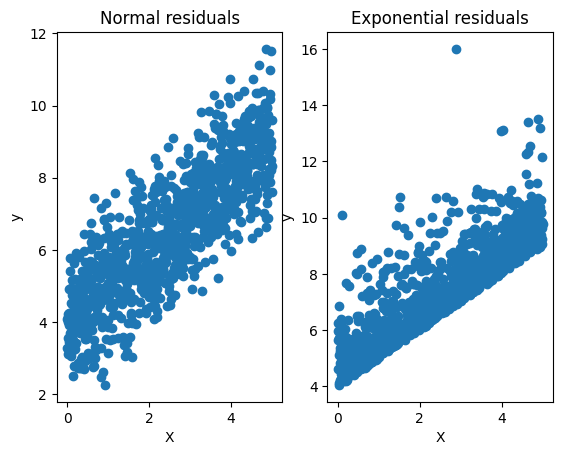

In [16]:
x = np.linspace(0,5,1000)

y1 = 4 + x +np.random.normal(size=x.shape)
y2 =  4 + x +np.random.exponential(size=x.shape)

plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols=  2)
axes[0].scatter(x, y1)
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[0].set_title("Normal residuals")


axes[1].scatter(x, y2)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("Exponential residuals")

In [17]:
data = pd.DataFrame(np.vstack([x, y2]).T, columns=['x', 'y'])
data.head()
model = smf.ols(data=data, formula='y ~ x').fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2301.
Date:                Fri, 24 Oct 2025   Prob (F-statistic):          2.34e-261
Time:                        14:13:54   Log-Likelihood:                -1379.8
No. Observations:                1000   AIC:                             2764.
Df Residuals:                     998   BIC:                             2773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9519      0.061     81.402      0.000       4.833       5.071
x              1.0106      0.021     47.969      0.000       0.969       1.052
==============================================================================
Omnibus:                      477.876   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3164.439
Skew:                           2.104   Prob(JB):                         0.00
Kurtosis:                      10.632   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

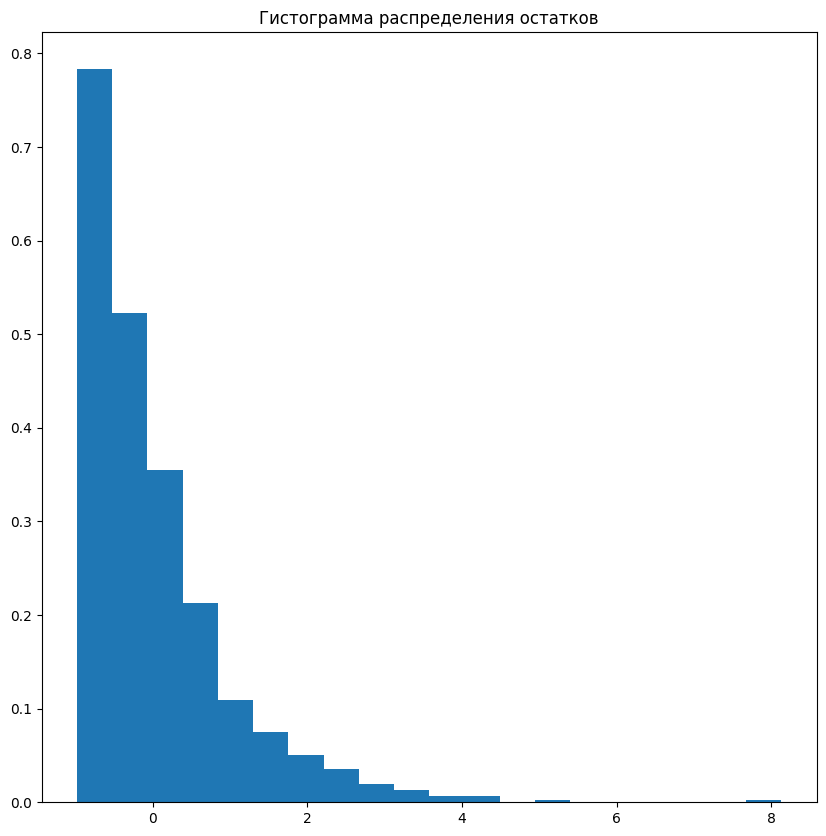

In [18]:
res = model.resid
counts, bins = np.histogram(res, bins=20, density=True)

plt.figure(figsize = (10,10))
plt.title('Гистограмма распределения остатков')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [19]:
# Критерий Колмогорова
print('Результаты теста К-С:', smd.kstest_normal(res))

# Критерий Андерсона-Дарлинга
print('Результаты теста А-Д:', smd.normal_ad(res))


Результаты теста К-С: (0.1541210689701547, 0.0009999999999998899)
Результаты теста А-Д: (inf, 0.0)


In [20]:
# Критерий Жарке-Бера выводится в саммари модели
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2301.
Date:                Fri, 24 Oct 2025   Prob (F-statistic):          2.34e-261
Time:                        14:17:09   Log-Likelihood:                -1379.8
No. Observations:                1000   AIC:                             2764.
Df Residuals:                     998   BIC:                             2773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9519      0.061     81.402      0.000       4.833       5.071
x              1.0106      0.021     47.969      0.000       0.969       1.052
==============================================================================
Omnibus:                      477.876   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3164.439
Skew:                           2.104   Prob(JB):                         0.00
Kurtosis:                      10.632   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Мощности тестов

In [ ]:
list(range(25, 100, 25))+list(range(100, 1000, 200))

[25, 50, 75, 100, 300, 500, 700, 900]

In [22]:
def check_power(max_sample_size=1000,
                num_samples = 1000,
                alpha = 0.05,
                errors_type='exponential'):
  portion_of_accepted_ks = dict()
  portion_of_accepted_ad = dict()
  portion_of_accepted_jb = dict()
  portion_of_accepted_om = dict()
  # итерируемся по размеру выборки
  if max_sample_size>100:
    sample_sizes = list(range(20, 100, 20))+list(range(100, max_sample_size, 200))
  else:
    sample_size =  list(range(20, max_sample_size, 10))
  for n in range(25, max_sample_size, 25):
    portion_of_accepted_ks[n] = 0
    portion_of_accepted_ad[n] = 0
    portion_of_accepted_jb[n] = 0
    portion_of_accepted_om[n] = 0

    # итерируемся по разным выборкам
    for i in range(num_samples):
      x = np.linspace(0,5,n)
      np.random.seed(n*i)

      # генерим y
      if errors_type == 'exponential':
        y =  4 + x +np.random.exponential(size=x.shape)
      elif errors_type == 'normal':
        y =  4 + x +np.random.normal(size=x.shape)

      data = pd.DataFrame(np.vstack([x, y]).T, columns=['x', 'y'])
      model = smf.ols(data=data, formula='y ~ x').fit()

      # выбираем тест
      p_values = [smd.kstest_normal(model.resid)[1], smd.normal_ad(model.resid)[1], smst.jarque_bera(model.resid)[1], smst.omni_normtest(model.resid)[1]]

      # обновляем значение доли принятых тестов
      if p_values[0]>alpha:
        portion_of_accepted_ks[n] += 1/num_samples
      if p_values[1]>alpha:
        portion_of_accepted_ad[n] += 1/num_samples
      if p_values[2]>alpha:
        portion_of_accepted_jb[n] += 1/num_samples
      if p_values[3]>alpha:
        portion_of_accepted_om[n] += 1/num_samples

  return portion_of_accepted_ks, portion_of_accepted_ad, portion_of_accepted_jb, portion_of_accepted_om

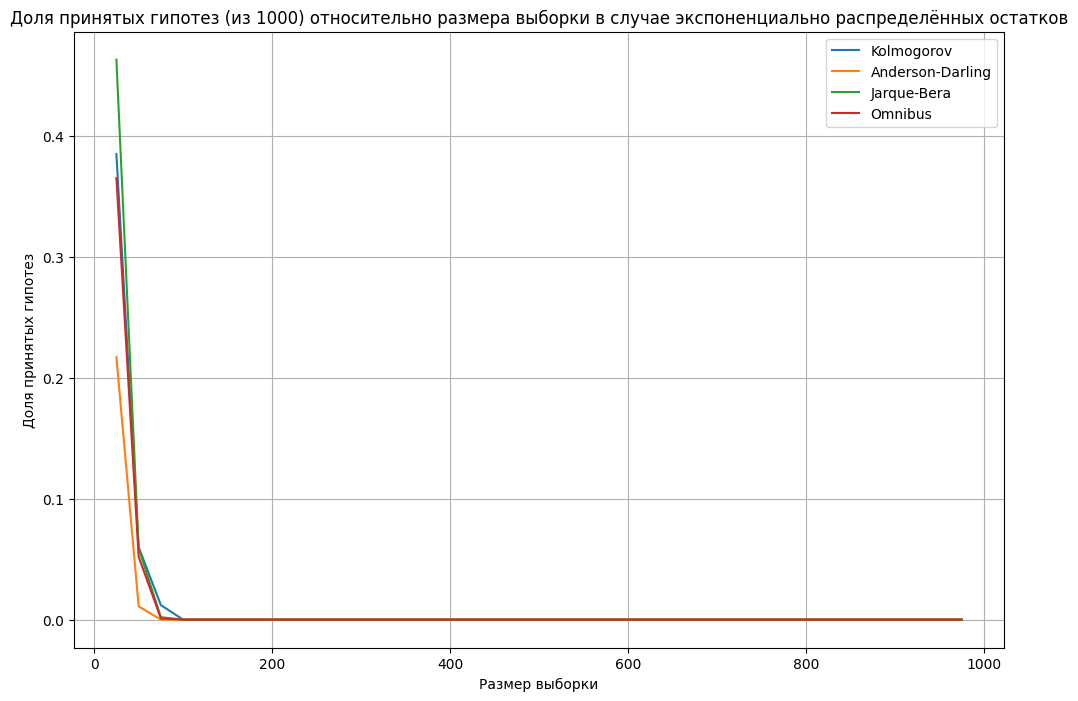

In [23]:
import warnings
warnings.filterwarnings("ignore")

ks_exp, ad_exp, jb_exp, om_exp = check_power()
ks_norm, ad_norm, jb_norm, om_norm = check_power(errors_type='normal')

plt.figure(figsize=(12, 8))
plt.plot(ks_exp.keys(), ks_exp.values(), label='Kolmogorov')
plt.plot(ad_exp.keys(), ad_exp.values(), label='Anderson-Darling')
plt.plot(jb_exp.keys(), jb_exp.values(), label='Jarque-Bera')
plt.plot(om_exp.keys(), om_exp.values(), label='Omnibus')

plt.legend()
plt.title('Доля принятых гипотез (из 1000) относительно размера выборки в случае экспоненциально распределённых остатков')
plt.grid()
plt.xlabel('Размер выборки')
plt.ylabel('Доля принятых гипотез')
plt.show()

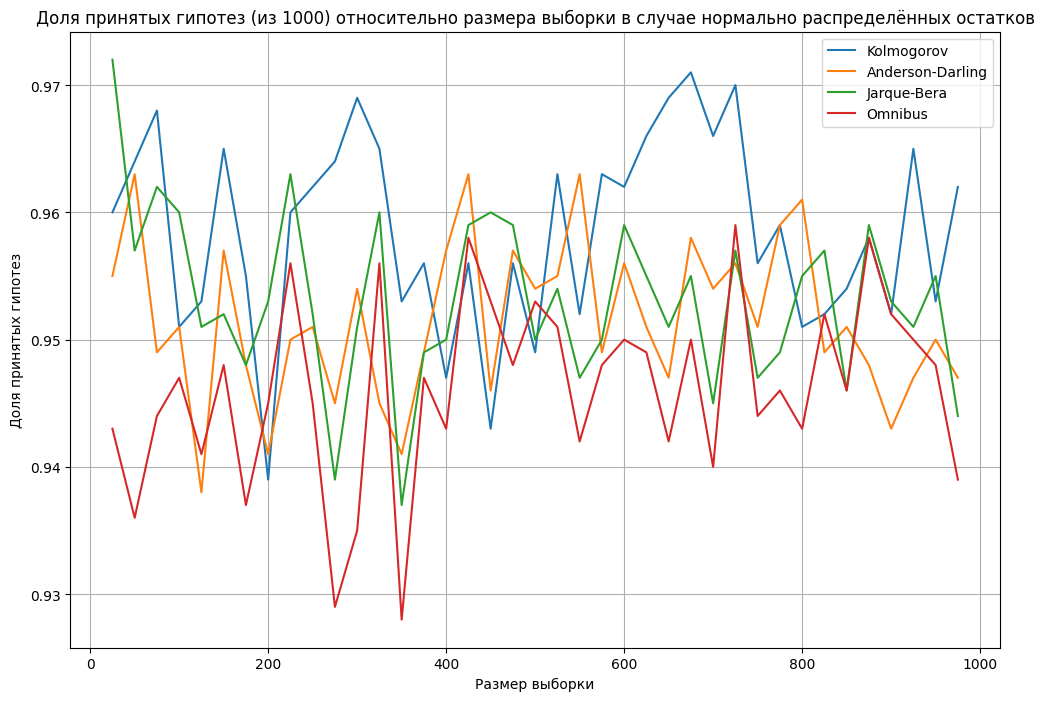

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(ks_norm.keys(), ks_norm.values(), label='Kolmogorov')
plt.plot(ad_norm.keys(), ad_norm.values(), label='Anderson-Darling')
plt.plot(jb_norm.keys(), jb_norm.values(), label='Jarque-Bera')
plt.plot(om_norm.keys(), om_norm.values(), label='Omnibus')

plt.legend()
plt.title('Доля принятых гипотез (из 1000) относительно размера выборки в случае нормально распределённых остатков')
plt.grid()
plt.xlabel('Размер выборки')
plt.ylabel('Доля принятых гипотез')
plt.show()

Если остатки негауссовские и никакая работа над признаками и целевой переменной не помогла, можно использовать обобщенную линенейную модель (GLS)

В качестве функции остатков в целом можно подать какую угодно плотность, главное, чтобы для нее существовали оценки ММП

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(x)

# в качестве распределения ошибок - выбираем Гамма-распределение (можно очень и очень много других делать)
model = sm.GLM(exog=X, endog=y2, family=sm.families.Gamma()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                        0.020071
Method:                          IRLS   Log-Likelihood:                -1392.9
Date:                Fri, 24 Oct 2025   Deviance:                       17.763
Time:                        14:34:49   Pearson chi2:                     20.0
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8514
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1844      0.001    130.620      0.000       0.182       0.187
x1            -0.0182      0.000    -43.414      0.000      -0.019      -0.017
==============================================================================
"""

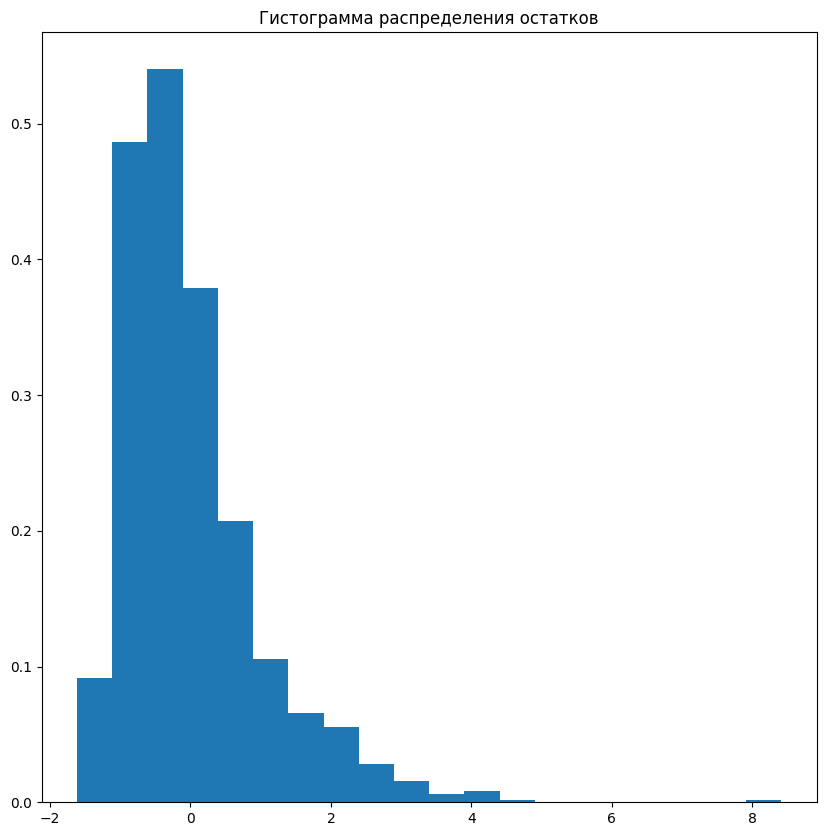

In [26]:
res = model.resid_response
counts, bins = np.histogram(res, bins=20, density=True)

plt.figure(figsize = (10,10))
plt.title('Гистограмма распределения остатков')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

## Эндогенность

Проблема неправильной спецификации модели: Спецификация модели связана с выбором функциональной формы, которая используется для анализа взаимосвязей между переменными. 

Фактически, первое предположение модели регрессии требует, чтобы модель была правильно задана. 

Другими словами, предполагается, что мы точно знаем, какие переменные следует включить. 
Однако на практике никто не может быть абсолютно уверен в том, что выбранная функциональная форма является правильной, поэтому возможны ошибки в спецификации.

### Пример на инструментальные переменные

In [37]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.api import add_constant
from statsmodels.sandbox.regression.gmm import IV2SLS

#Load the Panel Study of Income Dynamics (PSID) into a Dataframe

data = pd.read_csv("https://raw.githubusercontent.com/limph0nimph/psmo_linreg_classes/main/PSID1976.csv")
df_1975 = data.query('participation == \'yes\'')
df_1975['ln_wage'] = np.log(df_1975['wage'])
df_1975.columns

Index(['rownames', 'participation', 'hours', 'youngkids', 'oldkids', 'age',
       'education', 'wage', 'repwage', 'hhours', 'hage', 'heducation', 'hwage',
       'fincome', 'tax', 'meducation', 'feducation', 'unemp', 'city',
       'experience', 'college', 'hcollege', 'ln_wage'],
      dtype='object')

Мы ходим понять как образование и опыт работы влияет на зарплату.
Однако мы также знаем, что важным фактором является талант(Ability), но талант это невидимая переменная и данных на неё у нас нет.

Таким образом, истинная модель выглядит так:
$Log wage=β0+β_1Education+β_2Ability+β_3Experience$

Но мы можем оценить регрессию вида:
$Log wage=\alpha_0+\alpha_1Education+\alpha_2 Experience$

Однако на образование точно влияет талант(Ability). Тогда получается, что в данный модели будут проблема пропущенной переменной, так как
$cov(Education, Ability)>0$ и в данной регрессионной модели будут смещенные и несостоятельные оценки.

Что же делать, чтобы получить состоятельные оценки на параметры $\alpha_0,\alpha_1, \alpha_2$ 

Можно для переменной Education использовать инструментальные переменные, связанные с Education, но **не** связанные с талантом Ability.

Например, образование родителей в целом определяет образование человека, но не зависит от его таланта(Ability).

Тогда в качестве инструментальных переменных будет использовать meducation(образование матери) и feducation (образование отца)

Давайте с помощью инструментальных переменных оценим education, чтобы проверить наличие связи между meducation(образование матери) и feducation (образование отца) и education

In [33]:

#Build an train an OLS model that regresses education on meducation and feducation and verify
# using the F-test that coefficients of meducation and feducation are jointly significant
# significance
olsr_model = smf.ols(formula='education ~ meducation + feducation', data=df_1975)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     55.83
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           2.96e-22
Time:                        15:29:53   Log-Likelihood:                -910.64
No. Observations:                 428   AIC:                             1827.
Df Residuals:                     425   BIC:                             1839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4801      0.321     29.523      0.0

Да, зависят. Значит можем использовать их в качестве инструментов.

In [ ]:
#Build out the exog matrix. Statsmodels requires this matrix to contain all the endogenous and
# exogenous variables, plus the constant.
exog = df_1975[['education',"experience"]]
exog = add_constant(exog)

#Build out the instruments matrix. Statsmodels requires this matrix to contain not only all the
# instruments but also the variables in exog that will NOT be instrumented
instruments = df_1975[['meducation', 'feducation',"experience"]]
#instruments = add_constant(instruments)

#Build and train the IV2SLS model
iv2sls_model = IV2SLS(endog=df_1975['ln_wage'], exog=exog, instrument=instruments)
iv2sls_model_results = iv2sls_model.fit()

iv2sls_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.084
Model:                         IV2SLS   Adj. R-squared:                  0.080
Method:                     Two Stage   F-statistic:                     3.396
                        Least Squares   Prob (F-statistic):             0.0344
Date:                Fri, 24 Oct 2025                                         
Time:                        15:30:53                                         
No. Observations:                 428                                         
Df Residuals:                     425                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4732      2.725     -0.541      0.589      -6.829       3.882
education      0.1833      0.197      0.931      0.352      -0.204       0.570
experience     0.0235      0.014      1.689      0.092      -0.004       0.051
==============================================================================
Omnibus:                       66.428   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.634
Skew:                          -0.664   Prob(JB):                     8.29e-51
Kurtosis:                       6.342   Cond. No.                         113.
==============================================================================
"""

Сравним с базовой оценкой модели

In [ ]:
reg_expr = 'ln_wage ~ education + experience'
olsr_model = smf.ols(formula=reg_expr, data=df_1975)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

# оценки не совпадают

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     37.02
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           1.51e-15
Time:                        15:31:39   Log-Likelihood:                -433.74
No. Observations:                 428   AIC:                             873.5
Df Residuals:                     425   BIC:                             885.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4002      0.190     -2.102      0.0

### Критерий Дарбина-Ву-Хаусмана (тест Хаусмана)

Тест основан на сравнении коэффициентов регрессии инструментальных переменных с обычной регрессией OLS с использованием критерия хи-квадрат со степенями свободы, равными количеству
сравниваемых параметров.

При нулевой гипотезе об отсутствии одновременного смещения уравнения и OLS, и IV будут согласованными оценками, но OLS будет более эффективным.
Согласно альтернативной гипотезе, МНК будут противоречивыми, и это видно из значения теста (значительно отличающиеся
коэффициенты двух регрессий).

Тест позволяет провести различие между этими двумя возможностями.

$H_0$: разница в коэффициентах не является систематической ((u_i не зависит от регрессоров) правильная спецификация <=> нет эндогенности)

Однако, если тестовая статистика незначительна, это не обязательно означает, что нулевая гипотеза верна. 
Возможно, это неверно, но инструменты, используемые в IV, настолько слабы, что различия между оценками IV и OLS несущественны.

ПРАКТИКА: 

Применительно к предыдущей задаче:

* Протестируйте введенные инструменты на слабость с помощью интерпретации F-статистики в регрессии на инструментальные переменные

* Как еще можно проверить слабость инструментов?

* P.S. Слабые инструменты — это инструменты, которые плохо коррелируют с эндогенной переменной

In [38]:
# YOUR CODE HERE

Проведите тест Хаусмана

* Сначала напишите его самостоятельно

* А затем воспользуйтесь встроенным в linearmodels

* Проинтерпретируйте результаты


In [ ]:
# YOUR CODE HERE